In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import numpy as np
from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 14, 'lines.markersize' : 4})

from scipy.optimize import curve_fit
import sys, os
import time, datetime
from datetime import timedelta
import pandas as pd
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *
import h5py
from scipy.interpolate import interp1d
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
from cart2pol import PolarRebin
import scipy.ndimage as scimg

/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0][-1] = 0
my_cmap = ListedColormap(my_cmap)

In [124]:
def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>120) & (rs<420)]=1
nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,])


x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

nmask = np.reshape(rebin(rebin(maskhm,4),4),[64**2,]) #rebin later
nnmask = (rebin(np.reshape(nmask, [64,64]))).flatten()
nnmask = rebin(rebin(maskhm,4),4)
#nnmask = (rebin(np.reshape(nmask, [64,64])*(inbg))).flatten()
nnmask[nnmask<0.5] = 0
nnmask[nnmask>=0.5] = 1

maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale [(rs>120) & (rs<270)]=1

In [5]:
def make_quads(x0):
    quads=np.ones((1024,1024))
    quads[:512,:512]= x0[0]
    quads[:512,512:]= x0[1]
    quads[512:,:512]= x0[2]
    quads[512:,512:]= x0[3]
    return quads


In [6]:
MM = make_MM([-17.998,-2.74, 17.9, -17.39, 17.86, 8.52, -3.85, 17.9, 11.47, 47.86])

In [10]:
d1 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Mar12_112_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
d2 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Mar28_112_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
#d3 = np.load('torch_Aug17_131_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
d3 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Sep1_131_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
d4 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Mar23_125_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
d5 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Aug31_127_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
d6 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Mar14_121_datdict_Aug31.npy', allow_pickle = True)[()]['datall']
idx = np.where(d6['ID'] == 21)[0]
for i in range(len(idx)):
    d6[idx[i]]['Up_conv'] = False
d7 = np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Sep4_131_datdict_Aug31.npy', allow_pickle = True)[()]['datall']

In [101]:
np.load('/cds/home/p/paris/cVMI/clean recon July/torch_Mar12_112_datdict_Aug31.npy', allow_pickle = True)[()]['mdatname']

'/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy'

In [11]:
datall = np.concatenate([d1,d2,d3,d4,d5,d6,d7])

In [113]:
mdatname = ['/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy',\
            '/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar23_125.npy',\
            '/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug31_127.npy',\
            '/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug21_131.npy']

mdatname = np.array(mdatname)

runmdat = [112,125,127,131]
runmdat = np.array(runmdat)          
            

In [103]:
tmstmps = np.array([4410467689813058340, 4410467513749662082, 4410467613009185416, 4410467066956109577,\
           4410497995441170790, 4410495757465619491, 4410497737457767587, 4410497742469699341,\
           4410507263569544070, 4410507332768750257, 4410507134894447000, 4410507217196004681], dtype = np.uint64)


In [104]:
runs = []
IDs = []
for i in range(len(tmstmps)):
    runs.append(datall[datall['timestamp'] == tmstmps[i]]['run'][0])
    IDs.append(datall[datall['timestamp'] == tmstmps[i]]['ID'][0])
print(np.unique(runs))

[112 125 127 131]


In [122]:
mdatname[np.where(runmdat == runs[1])[0]]

array(['/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy'],
      dtype='<U64')

In [125]:
cVMIs = []
specs = []
unproc = []
raw = []
gds = []
timestamps = []

for i in range(len(tmstmps)):
    ds=ps.DataSource(exp = 'tmox51020', run= int(runs[i]), timestamps= np.array([tmstmps[i]],dtype = np.uint64))
    #ds=ps.DataSource(exp = 'tmox51020', run= runnum, filter = lambda evt:evt.timestamp in tt)

    run = next(ds.runs())
    opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
    gmd = run.Detector("gmd") # gas intensity detector 
    timing = run.Detector('timing') # this gives access to evr codes
    ebeam = run.Detector("ebeam")
    opalfzp = run.Detector('tmo_fzpopal') 



    if hasattr(run, 'epicsinfo'):
        epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
        epics_detectors = [run.Detector(item) for item in epics_strs]    

    for nevent, event in enumerate(run.events()):
        # fetch the information from the different events
        im_look=np.copy(opal1.raw.raw(event))  #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
        im1=im_look
        ims = np.rot90(im1*mask)
        #ims = cv2.warpPerspective(ims,MM,(1024,1024))
        gasoff = 0 #gasoff0#/np.mean(gasoff0)*np.mean(ims)
        ims = cv2.warpPerspective(ims-gasoff,MM,(1024,1024))
        raw.append(ims)
        ims[ims<0] = 0
        ims2 = np.copy(ims)
        # ims2 = mf(ims2, mfn)
        # ims2 = gf(ims2, gfn)
        ims2= rebin(rebin(ims2,4),4)
        unproc.append(ims2)
        mname = mdatname[np.where(runmdat == runs[i])[0]][0]
        print(mname)
        cVMIs.append(np.load(mname)[()][IDs[i]])

        '''
        fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
        axs[0].pcolormesh(ims2, cmap = my_cmap)
        axs[0].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
        axs[1].pcolormesh(testim, cmap = my_cmap)
        axs[1].plot((512+332*np.cos(phi_rad))/16, (512+332*np.sin(phi_rad))/16, 'r--', alpha = 0.5)
        plt.show()
        '''

        opalfz= np.copy(opalfzp.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
        zps_data = opalfz
        zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
        px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
        px_edge_width = 5 #spacing to integrate for the line out. 

        zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
        zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
        zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
        zps = zps-zps_bg
        spec = np.squeeze(fastsmooth1(zps,10))
        spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
        specs.append(spec)
        gd_i=gmd.raw.energy(event)
        gds.append(gd_i)
        print(event.timestamp) 
        timestamps.append(event.timestamp)

print('fanmask')

/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy
4410467689813058340
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy
4410467513749662082
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy
4410467613009185416
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy
4410467066956109577
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug31_127.npy
4410497995441170790
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar23_125.npy
4410495757465619491
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug31_127.npy
4410497737457767587
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug31_127.npy
4410497742469699341
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug21_131.npy
4410507263569544070
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug21_131.npy
4410507332768750257
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug21_131.npy
4410507134894447000
/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Aug21_131.npy


In [109]:
#basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_K5/'
basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_Feb/'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5') 


In [60]:
Ups = np.unique(datall['Up'])
Ups

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2])

In [64]:
gfsig = 0.985
gfcart = 0.25

In [65]:
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    if Up == 0: Up = int(0)
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Np128_Nw6_Nt6_Up0.npy


/tmp/ipykernel_14586/16415107.py:44: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_14586/16415107.py:51: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


Bpbasis_Np128_Nw6_Nt6_Up0.1.npy
Bpbasis_Np128_Nw6_Nt6_Up0.2.npy
Bpbasis_Np128_Nw6_Nt6_Up0.3.npy
Bpbasis_Np128_Nw6_Nt6_Up0.4.npy
Bpbasis_Np128_Nw6_Nt6_Up0.5.npy
Bpbasis_Np128_Nw6_Nt6_Up0.6.npy
Bpbasis_Np128_Nw6_Nt6_Up0.7.npy
Bpbasis_Np128_Nw6_Nt6_Up0.8.npy
Bpbasis_Np128_Nw6_Nt6_Up0.9.npy
Bpbasis_Np128_Nw6_Nt6_Up1.0.npy
Bpbasis_Np128_Nw6_Nt6_Up1.1.npy
Bpbasis_Np128_Nw6_Nt6_Up1.2.npy


In [66]:
Upsall = np.unique(datall['Up'])

In [83]:
dat[(dat['Up'] == uplook)]['Qs'][0]

array([-0.00785111, -0.01333102, -0.14342839, -0.06030688, -0.04111674,
        0.00562123, -0.05444751,  0.07517559,  0.19257736,  0.1143897 ,
        0.04698974,  0.01138719,  0.01640349, -0.03264576, -0.20682508,
       -0.03852275,  0.00983782, -0.00302694,  0.01897938, -0.02073578,
       -0.10456102, -0.10100742, -0.13849109, -0.03331345, -0.0341914 ,
       -0.13436803, -0.44307485,  0.34291297,  0.09442058,  0.11399801,
        0.02938381,  0.16027597,  0.93217534, -1.41604316,  0.77747959,
        0.05716928, -0.20125039,  0.43296474,  0.09466881,  0.0233933 ,
       -0.00426749,  0.03050333,  0.07361532,  0.2673344 , -0.04194149,
       -0.05872196, -0.03542174, -0.06376824, -0.04708365,  0.07123001,
       -0.07929292,  0.01089579,  0.03252152,  0.03712244,  0.04820964,
        0.58884788,  0.19370945, -0.03454194, -0.0194605 , -0.01649959,
       -0.05700758, -0.08788348, -0.4460659 ,  0.35505465,  0.12763077,
       -0.01378936, -0.0886662 , -0.43486652,  2.03775525,  0.06

In [ ]:
fwhms = []
std_t = []
ups_b = []
fwhms_avg = []
fwhms_maxs = []
fwhms2_maxs = []

eshift = 1
thresh = 0.0006
wr = 1200 #1340
phis = np.arange(0,360)*np.pi/180


X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>325-20) & (rs<420)]=1
mask1 = rebin(rebin(maskhm,4),4)


X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>325-30) & (rs<420)]=1
mask2 = rebin(rebin(maskhm,4),4)

for ii in range(len(tmstmps)):
    fig,axs = plt.subplots(ncols =7, figsize = (40,5))
    
    dat = datall[datall['timestamp'] == tmstmps[ii]]
    if dat['run'][0] == 112: 
        mask = mask2
        r = 18.1
    else: 
        mask = mask1
        r = 18.7

    axs[0].pcolormesh(raw[ii],cmap = my_cmap, vmin = 40)
    axs[0].plot(32*16+ 20*r*np.cos(phis), 32*16+ 20*r*np.sin(phis), 'k-', alpha = 0.5)
    
    axs[1].pcolormesh(unproc[ii],cmap = my_cmap, vmin = 40)
    axs[1].plot(32+r*np.cos(phis), 32+ r*np.sin(phis), 'k-', alpha = 0.5)
    
    
    
    cost_avg = []
    us = []
    for i,u in enumerate(np.unique(dat['Up'])):
        cost_avg.append(np.mean(dat[(dat['Up'] == u)]['costs'][:,-1]))
        us.append(u)

    uplook = us[np.argmin(cost_avg)]
    u = int(np.where(np.array(Upsall) == uplook)[0])
    seed_order = np.argsort(dat[(dat['Up'] == uplook)]['costs'][:,-1])
    seeds = np.unique(dat[(dat['Up'] == uplook)]['seed'])
    
    duration = []
    ets = []

    for ss in range(len(seeds)):   

        x = dat[(dat['seed'] == seeds[seed_order[ss]])]['Up']
        y= dat[(dat['seed'] == seeds[seed_order[ss]])]['costs'][:,-1]
        #y= dat[(dat['ID'] == IDs[k])]['costM'][:,-1]
        axs[4].plot(x[np.argsort(x)], y[np.argsort(x)], '-o', label = 'seed %1.0f' %seeds[seed_order[ss]])

        if ss == len(seeds)-1:
            axs[4].set_title('Up')
            axs[4].legend(fontsize = 8)


    Bp = Bps[u]
    vNaxis = vNaxiss[u]
    alpha = alphas[u]
    alphw = alphaws[u]
    ts= vNaxis['t_sample']

    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)


    m = cVMIs[ii]
    spec = dat[0]['spec']
    m = m/np.sum(m)
    N = 2801
    xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
    # xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
    eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
    #Interpolate spec outside of the loop to match eV
    xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
    xeV = xeV - eshift#3 #know this from previous calibration

    for s in range(len(seeds)):

        if len(seeds)>1:
            Q = np.squeeze(dat[(dat['Up'] == uplook)]['Qs'][seeds[seed_order[s]],:])
        else:
            Q = np.squeeze(dat[(dat['Up'] == uplook)]['Qs'])
        N_basis = 36
        eVshift_idx = 0
        Q1=Q[0:N_basis]
        Q1=np.reshape(Q1,[1,N_basis])
        Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
        Q2=np.reshape(Q2,[1,N_basis])
        Qguess=Q1+1j*Q2
        Qguess=np.reshape(Qguess,[N_basis,1])
        Mgr=np.real(np.matmul(np.matmul(Qguess,Qguess.conj().transpose()).transpose().flatten(),Bp))
        Mgr=Mgr/np.sum(Mgr)
        Mgr[Mgr<thresh] = 0
        Mgr=Mgr/np.sum(Mgr)

        alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
        #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
        Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

        f = interp1d(vNaxis['t_sample'],Et, fill_value = 0, bounds_error = False)
        Et_l = f(np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], len(vNaxis['t_sample'])))
        aghh = np.argmax(np.abs(Et_l))
        Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et_l,-aghh))) #need this to get imag part, must be evenly spaced
        #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
        EwEw = np.real(Ew*Ew.conj())
        EwEw = EwEw[wr-eVshift_idx:-wr-eVshift_idx]
        EwEw = EwEw/np.max(EwEw)
        wphase = np.unwrap(np.angle(Ew))
        wphase = wphase - np.mean(wphase)
        Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
        EwEw = np.real(Ew*Ew.conj())
        EwEw = EwEw[wr-eVshift_idx:-wr-eVshift_idx]
        EwEw = EwEw/np.max(EwEw)


    #             aghh = np.argmax(np.abs(Et))
    #             Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et,-aghh))) #need this to get imag part
    #             #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
    #             EwEw = np.real(Ew*Ew.conj())
    #             EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
    #             EwEw = EwEw/np.max(EwEw)
    #             wphase = np.unwrap(np.angle(Ew))
    #             wphase = wphase - np.mean(wphase)

        phis = np.linspace(0,359,100)*np.pi/180
        if s == 0:

            pscale = 1/np.max(m/np.sum(m*mask))
            Mt = m/np.sum(m*mask)*pscale
            Mp = pscale*np.reshape(Mgr/np.sum(mask*np.reshape(Mgr, [64,64])), [64,64])
            #Mp = Mp/np.max(Mp)
            #tosave[str(k) + '_Q'] = Q
            #tosave[str(k) + '_Up'] = uplook
            p =axs[2].pcolormesh(Mt, cmap = my_cmap,vmax = np.max([np.max(Mp),1]))
            axs[2].plot(32+r*np.cos(phis), 32+ r*np.sin(phis), 'k-', alpha = 0.5)
            #axs[2].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)
            #plt.colorbar(p, ax = axs[1])
            #axs[1].set_title(str(idn)+', '+str(uplook)+', GMD = %1.0f uJ' %(1000*gds[idn]))
            ups_b.append(uplook)

            p =axs[3].pcolormesh(Mp, cmap = my_cmap,vmax = np.max([np.max(Mp),1]))#, vmin = np.min(m), vmax = np.max(m))
            #plt.colorbar(p, ax = axs[2])
            phis = np.linspace(0,359,100)*np.pi/180
            axs[3].plot(32+r*np.cos(phis), 32+ r*np.sin(phis), 'k-', alpha = 0.5)
        ###axs[3].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'k-', alpha = 0.5)
            #axs[3].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)

            # p = axs[3].pcolormesh((Mt-Mp)*mask, cmap = 'bwr')
            # axs[3].set_title('%1.4f' %np.sum(np.abs(Mt-Mp)*mask))
            # #p = axs[2].pcolormesh(m-np.reshape(Mgr, [64,64]), cmap = 'bwr')
            # axs[3].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'k-', alpha = 0.5)
            # axs[3].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)
            # plt.colorbar(p, ax = axs[3])

            f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
            spec_in = f(eV[wr:-wr])
            ############# spec cal
            xxx1 = np.arange(len(spec_in))
            f = interp1d(xxx1, spec_in, fill_value = 0, bounds_error = False)
            xs = np.linspace((xxx1[0] -np.argmax(spec_in)), (xxx1[-1]-np.argmax(spec_in)), len(xxx1))+np.argmax(spec_in)
            spec_in = f(xs)
            #########

            spec_in=spec_in/np.max(spec_in)
            # ax1 = axs[6].twinx()
            # ax1.plot(eV[wr:-wr], spec_in, color= 'tab:green', alpha = 0.5)
            ax = axs[6].twinx()
            ax.plot(eV[wr:-wr], spec_in, color= 'tab:green', alpha = 0.5)



        #axs[l][4].set_title('t')
        axs[6].plot(np.linspace(eV[wr],eV[-wr], len(EwEw)), np.squeeze(EwEw))
        #ax.set_ylim(axs[5].get_ylim())
        EtEt = np.abs(Et*Et.conj())
        EtEt = EtEt/np.max(EtEt)
        axs[5].plot(ts[t1:t2]*1e15, EtEt[t1:t2],label = 'seed %1.0f' %seeds[seed_order[s]])
        #axs[5].grid()
        #axs[l][4].set_xlim(-4e-15,4e-15)

        roll_to = np.argmax(EtEt[t1:t2])
        # a,mu,sig = gaus_fit(ts*1e15,np.roll(EtEt, int(len(EtEt)/2)-roll_to))
        # duration.append(2.355*sig)

        #duration.append(FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to)))
        ets.append(EtEt)



        # axs[6].plot(eV[wr-eVshift_idx:-wr-eVshift_idx], wphase[wr-eVshift_idx:-wr-eVshift_idx])
        # mid = int(len(eV[wr-eVshift_idx:-wr-eVshift_idx])/4)
        # if s == 0: ymin,ymax = np.min(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid]),np.max(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid])
        # if s>0: 
        #     if np.min(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid]) < ymin: ymin = np.min(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid])
        #     if np.max(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid]) > ymax: ymax = np.max(wphase[wr-eVshift_idx:-wr-eVshift_idx][mid:-mid])
        # axs[6].set_ylim(ymin,ymax)
        if s == len(seeds)-1: axs[4].legend(fontsize = 8)
    #axs[4].set_title('t FWHM = %1.3f fs' %np.mean(duration)) 
    axs[6].set_xlim(-16,12)
    EtEtm = np.mean(ets,axis = 0)
    EtEtmax = np.max(ets,axis = 0)
    #fwhms2_maxs.append(FWHM2(ts[t1:t2]*1e15,np.roll(EtEtmax[t1:t2], int(len(EtEtmax[t1:t2])/2)--np.argmax(EtEtmax[t1:t2]))))
    #fwhms.append(np.mean(duration))
    #fwhms_avg.append(FWHM(ts*1e15, np.roll(EtEtm[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
    #fwhms_maxs.append(FWHM(ts*1e15, np.roll(EtEtmax[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
    #std_t.append(np.sum(np.std(np.array(ets),axis = 0)))

    #axs[1].set_title(str(idn)+', '+str(uplook)+', GMD = %1.0f uJ' %(1000*gds[idn]))
    axs[5].set_title('w')
    axs[6].set_title('w phase')

    axs[0].set_title('Raw? cVMI')
    axs[1].set_title('cVMI image')
    axs[2].set_title('Background Subtracted \nand Thresholded')
    axs[3].set_title('Reconstructed cVMI')
    axs[4].set_title('Up scan')
    axs[5].set_title('Temporal Reconstruction')
    axs[6].set_title('Spectral Reconstruction')
    #plt.suptitle('put the mask hole somewhere- superimpose it')
    # axs[1].pcolormesh(maskp, cmap = mask_cmap)
    # axs[2].pcolormesh(maskp, cmap = mask_cmap)
    # axs[3].pcolormesh(maskp, cmap = mask_cmap)
    axs[4].set_yticks([])
    axs[4].set_ylabel('Fit Cost Arb.')
    axs[5].set_xlabel('t [fs]')
    axs[6].set_xlabel(r'$\Delta\omega$ [eV]')
    #axs[5].grid()
    plt.show()
#print(eshift)

In [111]:
m = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy')[()]

In [88]:
IDs

[194, 171, 184, 114, 58, 13, 18, 24, 120, 140, 40, 88]

In [ ]:
mask_cmap = cm.get_cmap('binary_r')
xr = np.linspace(0, 1, 2000)
mask_cmap = mask_cmap(xr)
mask_cmap[-1000:][:,-1] = 0
mask_cmap[:1000][:,-1] = 0.7
mask_cmap = ListedColormap(mask_cmap)

(1024, 1024)

In [89]:
maskp = np.copy(mask)
X,Y=np.meshgrid(np.arange(64),np.arange(64))
rs=np.sqrt((X-32)**2+(Y-32)**2)
maskp[(rs>25)]=1

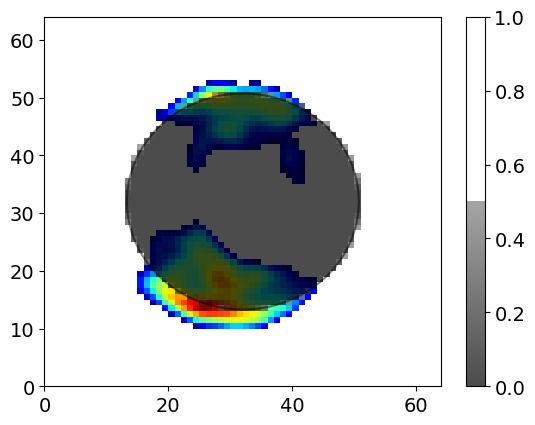

In [99]:
plt.pcolormesh(cVMIs[-1],cmap = my_cmap, vmin = 40)
plt.pcolormesh(maskp, cmap = mask_cmap)
plt.plot(32+18.7*np.cos(phis), 32+ 18.7*np.sin(phis), 'k-', alpha = 0.5) #18.1
plt.colorbar()

In [169]:
chose a characteristic shot 

0.2008056640625

In [ ]:
get the median pulse energy

sincd already cutting in beam energy, should include the lower shots below GMD threshold
can throwaway low energy if the spectra looks bad for the bandwidth one